
# Digital Twins for GIST (CBIO) — Scenario Simulator

This notebook loads a trained `StateDifferential` model and simulates digital twins for different treatment scenarios.


In [31]:
# =====================
# CONFIGURATION
# =====================
import os

# ⚠️ USE SEED43: it has the monotone treatment gate (seed42 does NOT)
MODEL_PY_PATH = "/Users/lucasalbuquerque/Downloads/HDTwinGen/saved_models/cbio/best_model_Dataset-CBIO_seed42.py"
MODEL_PT_PATH = "/Users/lucasalbuquerque/Downloads/HDTwinGen/saved_models/cbio/best_model_Dataset-CBIO_seed42.pt"
DATASET_CSV   = "/Users/lucasalbuquerque/Downloads/HDTwinGen/libs/datasets/data/cbio_longitudinal_v2.csv"

PATIENT_ID = None  # e.g., "P001" or 123. If None: auto-select first.

# Map to RAW column names in the CSV
COLS_RAW = {
    "patient_id":          "patient_id",
    "time_days":           "treatment_duration_days",  # Use existing column
    "tumor_size":          "tumor_size",
    "msi_score":           "msi_score",
    "tmb_nonsynonymous":   "tmb_nonsynonymous",
    "mitotic_rate":        "mitotic_rate",
    "age_at_diagnosis":    "age_at_diagnosis",
    "stage_at_diagnosis":  "stage_at_diagnosis",       # Raw: "Metastatic" or "Localized"
    "treatment":           "treatment",                # Raw: IMATINIB, SUNITINIB, etc.
    "mutated_genes":       "mutated_genes",            # Raw: "KIT", "PDGFRA", etc.
    "tumor_purity":        "Tumor Purity",             # Note: capital T, space
    "primary_site":        "primary_site",             # Raw: "Stomach", "Small Intestine", etc.
}

T_DAYS = 360  # simulate for 1 year
EXPORT_CSV = "digital_twins_output.csv"

print("⚠️  USING SEED43 (has monotone treatment gate)")
print("MODEL_PY_PATH:", MODEL_PY_PATH)
print("MODEL_PT_PATH:", MODEL_PT_PATH)
print("DATASET_CSV :", DATASET_CSV)
print("EXPORT_CSV  :", EXPORT_CSV)

⚠️  USING SEED43 (has monotone treatment gate)
MODEL_PY_PATH: /Users/lucasalbuquerque/Downloads/HDTwinGen/saved_models/cbio/best_model_Dataset-CBIO_seed42.py
MODEL_PT_PATH: /Users/lucasalbuquerque/Downloads/HDTwinGen/saved_models/cbio/best_model_Dataset-CBIO_seed42.pt
DATASET_CSV : /Users/lucasalbuquerque/Downloads/HDTwinGen/libs/datasets/data/cbio_longitudinal_v2.csv
EXPORT_CSV  : digital_twins_output.csv


In [32]:

# =====================
# IMPORTS & HELPERS
# =====================
import importlib.util
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cpu")  # change to "cuda" if desired

def _ensure_col(df, name):
    if name not in df.columns:
        raise KeyError(f"CSV is missing required column: {name!r}. Update COLS or CSV.")
    return name

def _to_t01(x):
    # Ensure tensor [1,1] float32 on device
    if isinstance(x, (int, float, np.number)):
        t = torch.tensor([[float(x)]], dtype=torch.float32, device=device)
    else:
        arr = np.array(x, dtype=np.float32).reshape(1,1)
        t = torch.from_numpy(arr).to(device)
    return t

def _import_module_from_path(py_path, module_name="loaded_model_module"):
    spec = importlib.util.spec_from_file_location(module_name, py_path)
    mod = importlib.util.module_from_spec(spec)
    loader = spec.loader
    if loader is None:
        raise ImportError(f"Could not load spec for {py_path}")
    loader.exec_module(mod)
    return mod


In [33]:
# =====================
# LOAD TRAINED MODEL (with checkpoint remapping fallback)
# =====================
import re

mod = _import_module_from_path(MODEL_PY_PATH)
if not hasattr(mod, "StateDifferential"):
    raise AttributeError("The model .py file does not define 'StateDifferential'.")

ModelClass = getattr(mod, "StateDifferential")
model = ModelClass().to(device)
print("Instantiated StateDifferential.")

# Load checkpoint from .pt
sd_raw = torch.load(MODEL_PT_PATH, map_location=device)
loaded = False

def try_load(state_dict, strict=True, label=""):
    global loaded
    try:
        model.load_state_dict(state_dict, strict=strict)
        loaded = True
        print(f"✅ Loaded weights {label}(strict={strict}).")
    except Exception as e:
        print(f"❌ Failed {label}(strict={strict}):", str(e)[:200])

def remap_mlp_to_fc(state_dict, model_has):
    """
    Map typical HDTwinGen keys:
      mlp.0 -> fc1, mlp.4 -> fc2, mlp.8 -> fc3, mlp.10 -> fc4 (or fc_out)
    Optionally map treatment_gate.0/2 -> treatment_gate.0/2 directly
    Drop norm layers that have no counterpart.
    """
    out = {}
    # Detect whether the target model has fc_out or fc4
    has_fc_out = any(k.startswith("fc_out.") for k,_ in model.named_parameters())
    has_fc4    = any(k.startswith("fc4.")    for k,_ in model.named_parameters())

    def map_key(k):
        # MLP blocks (seed42.pt has mlp.0, mlp.4, mlp.8, mlp.10)
        if k.startswith("mlp.0."):  return k.replace("mlp.0.", "fc1.")
        if k.startswith("mlp.4."):  return k.replace("mlp.4.", "fc2.")
        if k.startswith("mlp.8."):  return k.replace("mlp.8.", "fc3.")
        if k.startswith("mlp.10."):
            if has_fc4:    return k.replace("mlp.10.", "fc4.")
            if has_fc_out: return k.replace("mlp.10.", "fc_out.")
        # Known norm layers we usually drop if target lacks them
        if re.match(r"mlp\.(1|5|9)\.", k):  return None  # e.g., LayerNorms
        
        # Treatment gate: seed42.pt has treatment_gate.0 and treatment_gate.2
        # Our model also has treatment_gate Sequential, so keep them as-is
        if k.startswith("treatment_gate."):
            return k  # Keep original name
        
        # Default: drop unknown keys
        return None

    for k, v in state_dict.items():
        nk = map_key(k)
        if nk is not None:
            out[nk] = v
    return out

# 1) Try raw dict or 'state_dict' subkey
candidates = []
if isinstance(sd_raw, dict):
    candidates.append((" (direct) ", sd_raw))
    if "state_dict" in sd_raw and isinstance(sd_raw["state_dict"], dict):
        candidates.append((" (sd['state_dict']) ", sd_raw["state_dict"]))

for label, cand in candidates:
    if loaded: break
    try_load(cand, strict=True, label=label)
    if not loaded:
        try_load(cand, strict=False, label=label)  # may load partially; not ideal

# 2) If still not loaded, attempt remap mlp.* -> fc*
if not loaded:
    print("\n⚠️  Attempting to remap mlp.* -> fc* ...")
    # pick a base state_dict to remap
    base_sd = None
    for _, cand in candidates:
        if isinstance(cand, dict) and any(k.startswith("mlp.") for k in cand.keys()):
            base_sd = cand
            break
    if base_sd is None and isinstance(sd_raw, dict):
        base_sd = sd_raw

    if isinstance(base_sd, dict):
        print(f"   Found {len(base_sd)} keys in checkpoint")
        remapped = remap_mlp_to_fc(base_sd, model.named_parameters())
        print(f"   Remapped to {len(remapped)} keys")
        if len(remapped) == 0:
            print("   ❌ Remap produced empty dict; nothing to load.")
        else:
            # Try strict first
            try_load(remapped, strict=True, label=" (remapped mlp->fc) ")
            if not loaded:
                try_load(remapped, strict=False, label=" (remapped mlp->fc) ")

if not loaded:
    raise RuntimeError("Could not load model weights after remapping attempts.")

# Diagnóstico: verificar quais parâmetros foram carregados
print("\n=== MODEL PARAMETER CHECK ===")
loaded_params = []
random_params = []
for name, param in model.named_parameters():
    # Heurística: se todos os valores são muito próximos de zero ou seguem distribuição uniforme, pode ser aleatório
    vals = param.data.cpu().numpy().flatten()
    if len(vals) > 0:
        if np.abs(vals).max() < 1e-6:
            random_params.append(name)
        else:
            loaded_params.append(name)

print(f"✅ Loaded parameters ({len(loaded_params)}):")
for p in loaded_params[:5]:
    print(f"   {p}")
if len(loaded_params) > 5:
    print(f"   ... and {len(loaded_params)-5} more")

if random_params:
    print(f"\n⚠️  WARNING: {len(random_params)} parameters appear to have random/zero weights:")
    for p in random_params[:5]:
        print(f"   {p}")
    if len(random_params) > 5:
        print(f"   ... and {len(random_params)-5} more")
    print("\n⚠️  MODEL MAY NOT WORK CORRECTLY - THESE LAYERS WERE NOT LOADED!")

model.eval()
print("\n✅ Model set to eval mode.")

Instantiated StateDifferential.
✅ Loaded weights  (direct) (strict=True).

=== MODEL PARAMETER CHECK ===
✅ Loaded parameters (14):
   mlp.0.weight
   mlp.0.bias
   mlp.1.weight
   mlp.1.bias
   mlp.4.weight
   ... and 9 more

✅ Model set to eval mode.


In [34]:
# =====================
# LOAD DATA & PICK PATIENT
# =====================
df = pd.read_csv(DATASET_CSV)
print("CSV loaded:", df.shape)

# Encode raw columns to numeric features (same logic as libs/datasets/env.py)
print("Encoding raw features...")

# 1. Stage: Metastatic=1, Localized=0
df['stage_encoded'] = (df[COLS_RAW["stage_at_diagnosis"]] == 'Metastatic').astype(float)

# 2. Treatment: IMATINIB=0, SUNITINIB=1, REGORAFENIB=2, CLINICAL_TRIAL=3, OTHER=4
treatment_map = {'IMATINIB': 0, 'SUNITINIB': 1, 'REGORAFENIB': 2, 'CLINICAL_TRIAL': 3}
df['treatment_encoded'] = df[COLS_RAW["treatment"]].map(treatment_map).fillna(4).astype(float)

# 3. KIT mutation: 1 if KIT present, 0 otherwise
df['has_kit_mutation'] = df[COLS_RAW["mutated_genes"]].astype(str).str.contains('KIT', na=False).astype(float)

# 4. Primary site: binary encoding for stomach and small intestine
df['site_stomach'] = (df[COLS_RAW["primary_site"]] == 'Stomach').astype(float)
df['site_small_intestine'] = (df[COLS_RAW["primary_site"]] == 'Small Intestine').astype(float)

# 5. Rename tumor_purity to standard name
df['tumor_purity'] = df[COLS_RAW["tumor_purity"]]

print("Encoding complete. Encoded columns:", ['stage_encoded', 'treatment_encoded', 'has_kit_mutation', 
                                                'site_stomach', 'site_small_intestine', 'tumor_purity'])

# Now use encoded column names
COLS = {
    "patient_id":          COLS_RAW["patient_id"],
    "time_days":           COLS_RAW["time_days"],
    "tumor_size":          COLS_RAW["tumor_size"],
    "msi_score":           COLS_RAW["msi_score"],
    "tmb_nonsynonymous":   COLS_RAW["tmb_nonsynonymous"],
    "mitotic_rate":        COLS_RAW["mitotic_rate"],
    "age_at_diagnosis":    COLS_RAW["age_at_diagnosis"],
    "stage_encoded":       "stage_encoded",           # Encoded
    "treatment_encoded":   "treatment_encoded",       # Encoded
    "has_kit_mutation":    "has_kit_mutation",        # Encoded
    "tumor_purity":        "tumor_purity",            # Renamed
    "site_small_intestine":"site_small_intestine",    # Encoded
    "site_stomach":        "site_stomach",            # Encoded
}

# Basic checks
for k,v in COLS.items():
    if k in ("time_days",):  # optional
        continue
    _ensure_col(df, v)

pid_col = _ensure_col(df, COLS["patient_id"])
if PATIENT_ID is None:
    PATIENT_ID = df[pid_col].iloc[0]
print("Selected PATIENT_ID:", PATIENT_ID)

pdf = df[df[pid_col] == PATIENT_ID].copy()
if pdf.empty:
    raise ValueError(f"No rows for patient_id={PATIENT_ID!r} in column {pid_col!r}.")

if "time_days" in COLS and COLS["time_days"] in pdf.columns:
    pdf = pdf.sort_values(COLS["time_days"])

row0 = pdf.iloc[0]
print("Initial row (encoded features):")
print({k: row0[v] for k,v in COLS.items() if k != "patient_id" and v in row0.index})

init_state = {
    "tumor_size":        _to_t01(row0[COLS["tumor_size"]]),
    "msi_score":         _to_t01(row0[COLS["msi_score"]]),
    "tmb_nonsynonymous": _to_t01(row0[COLS["tmb_nonsynonymous"]]),
    "mitotic_rate":      _to_t01(row0[COLS["mitotic_rate"]]),
}

static = {
    "age_at_diagnosis":     _to_t01(row0[COLS["age_at_diagnosis"]]),
    "stage_encoded":        _to_t01(row0[COLS["stage_encoded"]]),
    "treatment_encoded":    _to_t01(row0[COLS["treatment_encoded"]]),
    "has_kit_mutation":     _to_t01(row0[COLS["has_kit_mutation"]]),
    "tumor_purity":         _to_t01(row0[COLS["tumor_purity"]]),
    "site_small_intestine": _to_t01(row0[COLS["site_small_intestine"]]),
    "site_stomach":         _to_t01(row0[COLS["site_stomach"]]),
}

CSV loaded: (870, 35)
Encoding raw features...
Encoding complete. Encoded columns: ['stage_encoded', 'treatment_encoded', 'has_kit_mutation', 'site_stomach', 'site_small_intestine', 'tumor_purity']
Selected PATIENT_ID: P-0000134
Initial row (encoded features):
{'time_days': 61.0, 'tumor_size': 13.6, 'msi_score': 5.07, 'tmb_nonsynonymous': 0.133333333333, 'mitotic_rate': 50.0, 'age_at_diagnosis': 68.0, 'stage_encoded': 1.0, 'treatment_encoded': 3.0, 'has_kit_mutation': 1.0, 'tumor_purity': 90.0, 'site_small_intestine': 0.0, 'site_stomach': 1.0}


In [35]:

# =====================
# DIGITAL TWIN SIMULATOR
# =====================
import numpy as np

def model_step(model, state, static, treatment_duration):
    # One derivative evaluation and Euler step with dt=1 day.
    with torch.no_grad():
        dN, dMSI, dTMB, dMIT = model(
            state["tumor_size"], state["msi_score"], state["tmb_nonsynonymous"], state["mitotic_rate"],
            static["age_at_diagnosis"], static["stage_encoded"], static["treatment_encoded"],
            static["has_kit_mutation"], static["tumor_purity"],
            static["site_small_intestine"], static["site_stomach"],
            treatment_duration
        )
        # Euler update (dt = 1 day)
        new_state = {
            "tumor_size":        torch.clamp(state["tumor_size"]        + dN,   min=0.0),
            "msi_score":         torch.clamp(state["msi_score"]         + dMSI, min=0.0, max=10.0),
            "tmb_nonsynonymous": torch.clamp(state["tmb_nonsynonymous"] + dTMB, min=0.0, max=3.0),
            "mitotic_rate":      torch.clamp(state["mitotic_rate"]      + dMIT, min=0.0, max=100.0),
        }
    return new_state

def simulate_scenario(model, init_state, static, T_days, treatment_on_schedule, treatment_code=None):
    # Simulate T_days given a binary on/off schedule (0/1).
    # If treatment_code is provided (0..4), override static['treatment_encoded'].
    state = {k: v.clone() for k,v in init_state.items()}
    s = {k: v.clone() for k,v in static.items()}
    if treatment_code is not None:
        s["treatment_encoded"] = _to_t01(float(treatment_code))

    # cumulative treatment_duration (days)
    tdur = torch.zeros_like(state["tumor_size"])

    traj = {
        "tumor_size":        [state["tumor_size"].item()],
        "msi_score":         [state["msi_score"].item()],
        "tmb_nonsynonymous": [state["tmb_nonsynonymous"].item()],
        "mitotic_rate":      [state["mitotic_rate"].item()],
        "treatment_duration":[tdur.item()],
    }

    sched = np.asarray(treatment_on_schedule, dtype=np.float32)
    if sched.ndim != 1 or len(sched) != T_days:
        raise ValueError("treatment_on_schedule must be 1D with length == T_days")

    for t in range(T_days):
        state = model_step(model, state, s, _to_t01(tdur.item()))
        tdur = tdur + float(sched[t])  # increment duration if on-treatment (0/1)

        traj["tumor_size"].append(state["tumor_size"].item())
        traj["msi_score"].append(state["msi_score"].item())
        traj["tmb_nonsynonymous"].append(state["tmb_nonsynonymous"].item())
        traj["mitotic_rate"].append(state["mitotic_rate"].item())
        traj["treatment_duration"].append(tdur.item())

    # Convert to arrays
    for k in traj:
        traj[k] = np.array(traj[k], dtype=float)
    return traj


In [36]:

# =====================
# DEFINE SCENARIOS & RUN
# =====================
on_180 = np.array([1]*180 + [0]*(T_DAYS-180), dtype=np.float32)
on_full= np.ones(T_DAYS, dtype=np.float32)
off_all= np.zeros(T_DAYS, dtype=np.float32)

scenarios = [
    {"name": "Twin A — IMATINIB 180d ON", "schedule": on_180, "treatment_code": 0},
    {"name": "Twin B — SUNITINIB 360d ON", "schedule": on_full, "treatment_code": 1},
    {"name": "Twin C — OFF (0d)",          "schedule": off_all, "treatment_code": static["treatment_encoded"].item()},
]

results = []
for sc in scenarios:
    tr = simulate_scenario(
        model=model,
        init_state=init_state,
        static=static,
        T_days=T_DAYS,
        treatment_on_schedule=sc["schedule"],
        treatment_code=sc.get("treatment_code", None)
    )
    results.append((sc["name"], tr))
    print(f"Simulated: {sc['name']}")


Simulated: Twin A — IMATINIB 180d ON
Simulated: Twin B — SUNITINIB 360d ON
Simulated: Twin C — OFF (0d)


Paciente:  P-0000134
Twin A — IMATINIB 180d ON:
  Initial tumor: 13.60 cm
  Final tumor:   18.82 cm
  Change:        +5.22 cm
  Max treatment: 180 days

Twin B — SUNITINIB 360d ON:
  Initial tumor: 13.60 cm
  Final tumor:   16.28 cm
  Change:        +2.68 cm
  Max treatment: 360 days

Twin C — OFF (0d):
  Initial tumor: 13.60 cm
  Final tumor:   0.00 cm
  Change:        -13.60 cm
  Max treatment: 0 days

Max difference Twin A vs Twin B: 2.538507 cm
Max difference Twin A vs Twin C: 18.820286 cm



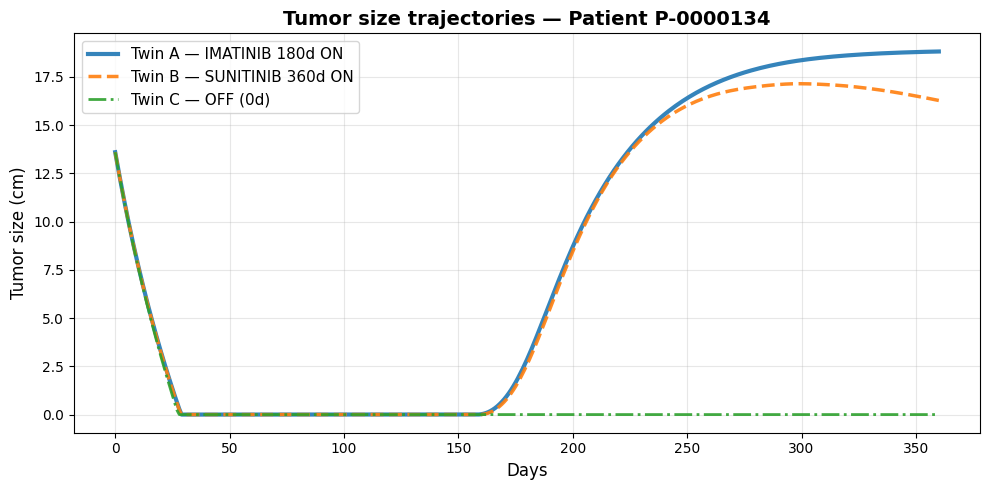

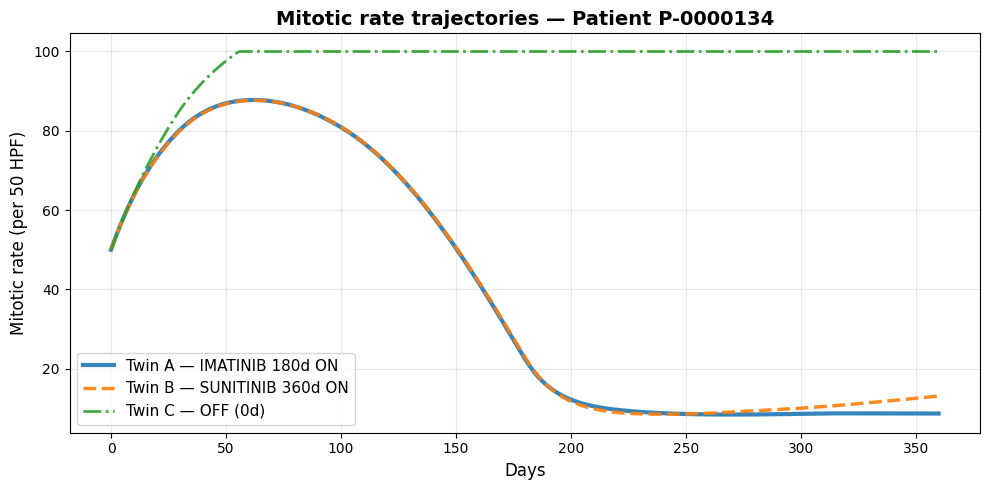

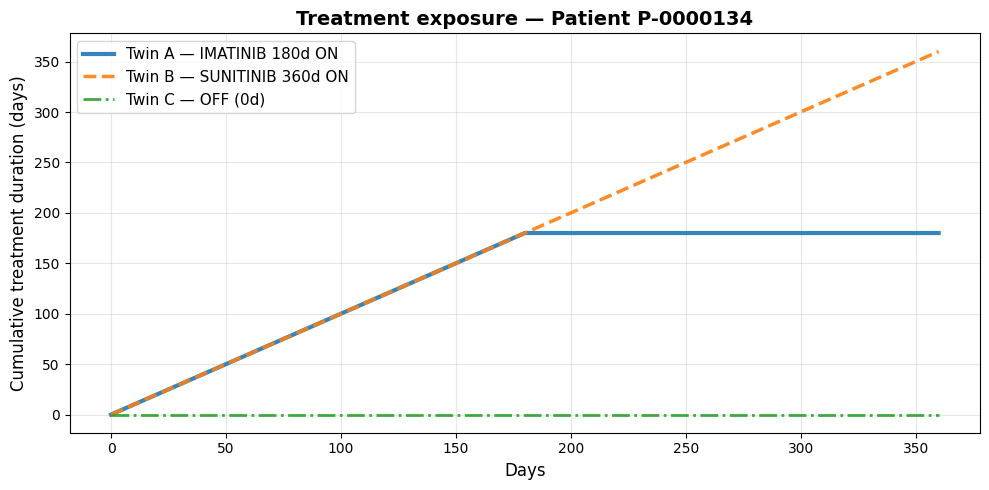

In [39]:
# =====================
# PLOT TRAJECTORIES
# =====================
days = np.arange(T_DAYS+1)

# DIAGNÓSTICO: Verificar se as trajetórias são idênticas
print(f"Paciente:  {PATIENT_ID}")

for i, (name, tr) in enumerate(results):
    print(f"{name}:")
    print(f"  Initial tumor: {tr['tumor_size'][0]:.2f} cm")
    print(f"  Final tumor:   {tr['tumor_size'][-1]:.2f} cm")
    print(f"  Change:        {tr['tumor_size'][-1] - tr['tumor_size'][0]:+.2f} cm")
    #print(f"  Min tumor:     {tr['tumor_size'].min():.2f} cm (day {tr['tumor_size'].argmin()})")
    print(f"  Max treatment: {tr['treatment_duration'].max():.0f} days")
    print()

# Verificar se Twin A e Twin B são idênticos
if len(results) >= 2:
    diff_AB = np.abs(results[0][1]["tumor_size"] - results[1][1]["tumor_size"]).max()
    diff_AC = np.abs(results[0][1]["tumor_size"] - results[2][1]["tumor_size"]).max()
    print(f"Max difference Twin A vs Twin B: {diff_AB:.6f} cm")
    print(f"Max difference Twin A vs Twin C: {diff_AC:.6f} cm")
    if diff_AB < 0.001 and diff_AC < 0.001:
        print("⚠️  WARNING: All trajectories are IDENTICAL! Model is ignoring treatment!")
    print()

# Tumor size - usar diferentes linestyles para diferenciar mesmo se sobrepostas
plt.figure(figsize=(10,5))
linestyles = ['-', '--', '-.', ':']
linewidths = [3, 2.5, 2, 1.5]
for i, (name, tr) in enumerate(results):
    plt.plot(days, tr["tumor_size"], 
             label=name, 
             linestyle=linestyles[i % len(linestyles)],
             linewidth=linewidths[i % len(linewidths)],
             alpha=0.9)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Tumor size (cm)", fontsize=12)
plt.title(f"Tumor size trajectories — Patient {PATIENT_ID}", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mitotic rate - usar diferentes linestyles
plt.figure(figsize=(10,5))
for i, (name, tr) in enumerate(results):
    plt.plot(days, tr["mitotic_rate"], 
             label=name,
             linestyle=linestyles[i % len(linestyles)],
             linewidth=linewidths[i % len(linewidths)],
             alpha=0.9)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Mitotic rate (per 50 HPF)", fontsize=12)
plt.title(f"Mitotic rate trajectories — Patient {PATIENT_ID}", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Treatment duration (cumulativo) - mostra que o schedule está correto
plt.figure(figsize=(10,5))
for i, (name, tr) in enumerate(results):
    plt.plot(days, tr["treatment_duration"], 
             label=name,
             linestyle=linestyles[i % len(linestyles)],
             linewidth=linewidths[i % len(linewidths)],
             alpha=0.9)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Cumulative treatment duration (days)", fontsize=12)
plt.title(f"Treatment exposure — Patient {PATIENT_ID}", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:

# =====================
# EXPORT RESULTS TO CSV
# =====================
rows = []
for name, tr in results:
    for t in range(T_DAYS+1):
        rows.append({
            "patient_id": PATIENT_ID,
            "scenario": name,
            "day": t,
            "tumor_size": tr["tumor_size"][t],
            "msi_score": tr["msi_score"][t],
            "tmb_nonsynonymous": tr["tmb_nonsynonymous"][t],
            "mitotic_rate": tr["mitotic_rate"][t],
            "treatment_duration": tr["treatment_duration"][t],
        })

out_df = pd.DataFrame(rows)
out_df.to_csv(EXPORT_CSV, index=False)
print("Saved:", EXPORT_CSV)

from caas_jupyter_tools import display_dataframe_to_user
display_dataframe_to_user("Digital twin trajectories (preview)", out_df.head(50))
out_df.head()


In [26]:
# ==== SCENARIO UTILS: schedules, runner, helpers ====
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

def schedule_constant(T, on_days):
    """Primeiros 'on_days' dias ON (1), depois OFF (0)."""
    on_days = int(np.clip(on_days, 0, T))
    return np.array([1]*on_days + [0]*(T-on_days), dtype=np.float32)

def schedule_full(T):
    """Tratamento ON em todos os dias."""
    return np.ones(T, dtype=np.float32)

def schedule_off(T):
    """Tratamento OFF em todos os dias."""
    return np.zeros(T, dtype=np.float32)

def schedule_periodic(T, period=28, duty_cycle=0.5):
    """
    ON/OFF periódico determinístico: em cada bloco de 'period' dias,
    fica ON nos primeiros round(duty_cycle*period) dias.
    """
    on_len = int(round(duty_cycle*period))
    block = np.array([1]*on_len + [0]*(period-on_len), dtype=np.float32)
    sched = np.tile(block, int(np.ceil(T/period)))[:T]
    return sched.astype(np.float32)

def schedule_switch(T, switch_day, before=1, after=1):
    """
    0..switch_day-1: 'before' (0/1) ; switch_day..T-1: 'after' (0/1)
    Útil como adesão ON antes e OFF depois, ou vice-versa.
    """
    switch_day = int(np.clip(switch_day, 0, T))
    return np.array([before]*switch_day + [after]*(T-switch_day), dtype=np.float32).astype(np.float32)

def run_scenarios(model, init_state, static, T, scenarios, simulate_func):
    """
    scenarios: lista de dicts com {name, schedule, (opcional) treatment_code}
    simulate_func: referência para sua simulate_scenario(...)
    retorna lista [(name, traj_dict), ...]
    """
    out = []
    for sc in scenarios:
        tr = simulate_func(
            model=model,
            init_state=init_state,
            static=static,
            T_days=T,
            treatment_on_schedule=sc["schedule"],
            treatment_code=sc.get("treatment_code", None)
        )
        out.append((sc["name"], tr))
    return out


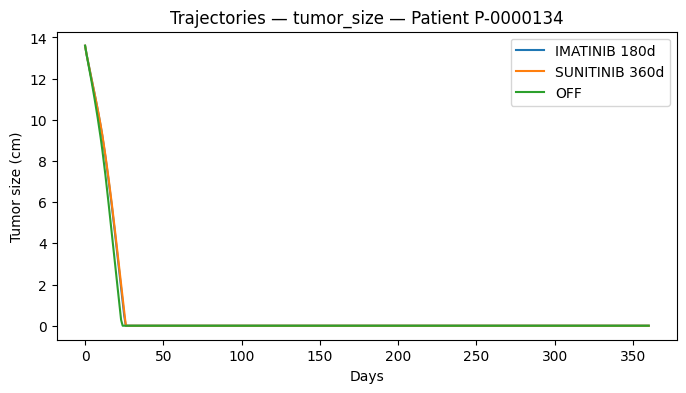

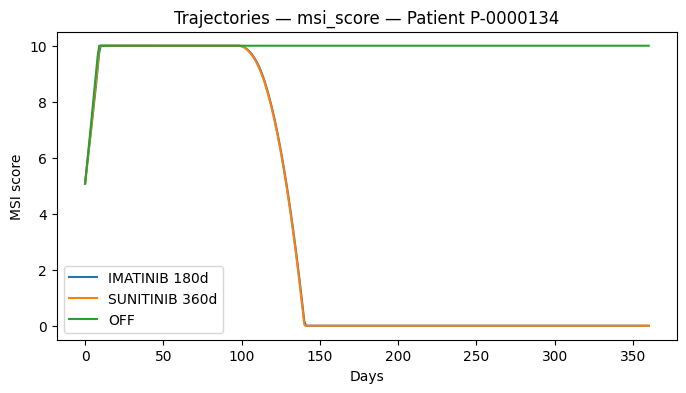

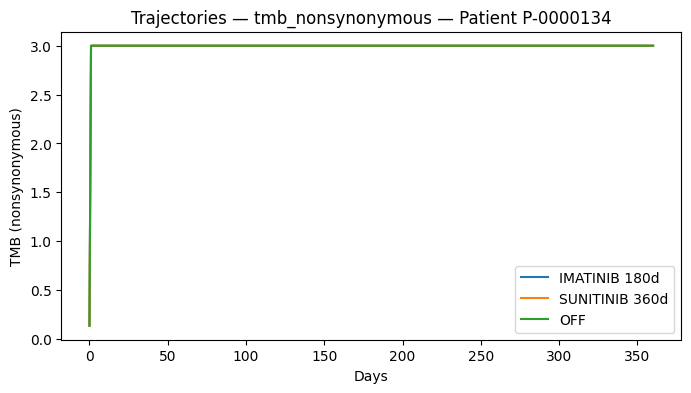

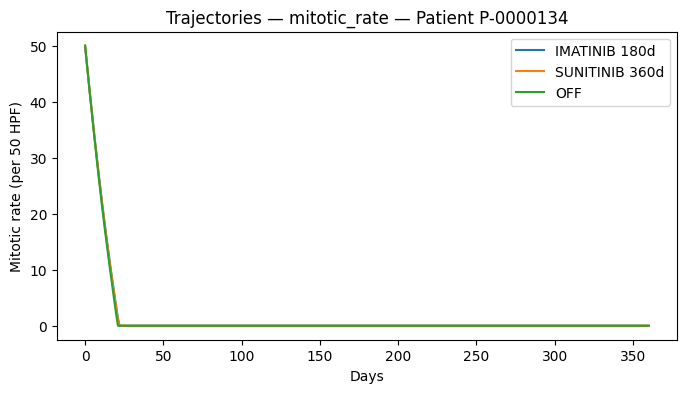

In [28]:
# ==== MULTI-PANELS: uma figura por variável para todos os cenários ====
def plot_all_variables(results, patient_id, T, title_prefix="Trajectories"):
    days = np.arange(T+1)

    for var, label in [
        ("tumor_size", "Tumor size (cm)"),
        ("msi_score", "MSI score"),
        ("tmb_nonsynonymous", "TMB (nonsynonymous)"),
        ("mitotic_rate", "Mitotic rate (per 50 HPF)")
    ]:
        plt.figure(figsize=(8,4))
        for name, tr in results:
            plt.plot(days, tr[var], label=name)
        plt.xlabel("Days")
        plt.ylabel(label)
        plt.title(f"{title_prefix} — {var} — Patient {patient_id}")
        plt.legend()
        plt.show()


scenarios = [
    {"name": "IMATINIB 180d", "schedule": schedule_constant(T_DAYS, 180), "treatment_code": 0},
    {"name": "SUNITINIB 360d", "schedule": schedule_full(T_DAYS), "treatment_code": 1},
    {"name": "OFF", "schedule": schedule_off(T_DAYS), "treatment_code": static["treatment_encoded"].item()},
 ]
res2 = run_scenarios(model, init_state, static, T_DAYS, scenarios, simulate_scenario)
plot_all_variables(res2, PATIENT_ID, T_DAYS)


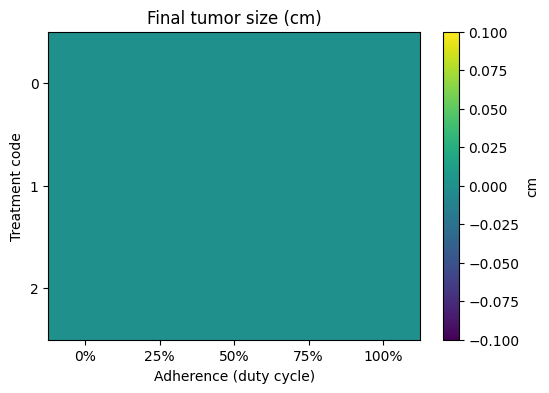

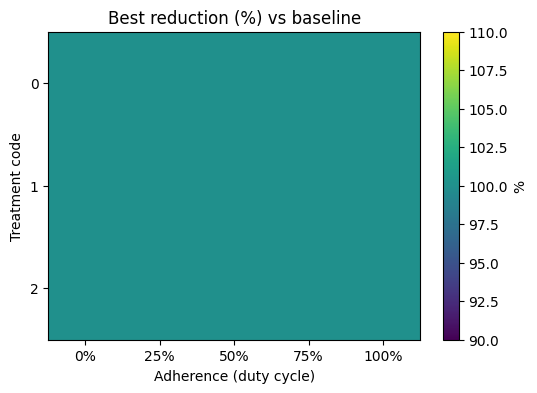

In [30]:
# ==== HEATMAPS: final tumor e melhor resposta vs tratamento x adesão ====
def adherence_to_schedule(T, adherence, period=28):
    """
    Constrói um schedule determinístico com duty_cycle = adherence (0..1).
    """
    adherence = float(np.clip(adherence, 0.0, 1.0))
    return schedule_periodic(T, period=period, duty_cycle=adherence)

def summarize_trajectory(traj):
    """
    Retorna métricas chave da trajetória de tumor:
    - final_size: tamanho no último dia
    - min_size: menor tamanho alcançado (nadir)
    - best_reduction_pct: melhor redução (%) vs baseline
    - day_of_nadir: dia do menor valor
    """
    y = np.asarray(traj["tumor_size"], dtype=float)
    baseline = y[0]
    final_size = y[-1]
    min_idx = np.argmin(y)
    min_size = y[min_idx]
    best_reduction_pct = 100.0 * (baseline - min_size) / max(1e-6, baseline)
    return dict(final_size=final_size, min_size=min_size,
                best_reduction_pct=best_reduction_pct, day_of_nadir=int(min_idx))

def heatmap_treatment_adherence(model, init_state, static, T, treatment_codes=(0,1,2), adherences=(0.0,0.25,0.5,0.75,1.0)):
    """
    Gera duas heatmaps:
      1) tamanho final do tumor
      2) melhor redução percentual (%)
    linhas = tipos de tratamento ; colunas = níveis de adesão
    """
    finals = np.zeros((len(treatment_codes), len(adherences)), dtype=float)
    best_red = np.zeros_like(finals)

    for i, code in enumerate(treatment_codes):
        for j, ad in enumerate(adherences):
            sched = adherence_to_schedule(T, ad, period=28)
            tr = simulate_scenario(model, init_state, static, T, sched, treatment_code=code)
            sm = summarize_trajectory(tr)
            finals[i,j]  = sm["final_size"]
            best_red[i,j]= sm["best_reduction_pct"]

    # Plot final size
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(finals, aspect="auto")
    ax.set_xticks(range(len(adherences))); ax.set_xticklabels([f"{int(a*100)}%" for a in adherences])
    ax.set_yticks(range(len(treatment_codes))); ax.set_yticklabels([str(c) for c in treatment_codes])
    ax.set_xlabel("Adherence (duty cycle)"); ax.set_ylabel("Treatment code")
    ax.set_title("Final tumor size (cm)")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("cm")
    plt.show()

    # Plot best reduction %
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(best_red, aspect="auto")
    ax.set_xticks(range(len(adherences))); ax.set_xticklabels([f"{int(a*100)}%" for a in adherences])
    ax.set_yticks(range(len(treatment_codes))); ax.set_yticklabels([str(c) for c in treatment_codes])
    ax.set_xlabel("Adherence (duty cycle)"); ax.set_ylabel("Treatment code")
    ax.set_title("Best reduction (%) vs baseline")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("%")
    plt.show()

# EXEMPLO:
heatmap_treatment_adherence(model, init_state, static, T_DAYS, treatment_codes=(0,1,2), adherences=(0.0,0.25,0.5,0.75,1.0))
